In [43]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [44]:
# Display options
pd.set_option('display.max_columns', None)

In [ ]:
BEST_PATH = "data/clean_best_sellers_all_category_20251025.csv"
MOVERS_PATH = "data/clean_movers_shakers_all_category_20251025.csv"
OUT_DIR = "./outputs"
os.makedirs(OUT_DIR, exist_ok=True)

In [46]:
def load_data(path):
    df = pd.read_csv(path)

    numeric_cols = [
        "rank",
        "page",
        "rating",
        "review_count",
        "price_norm",
        "move_pct",
        "sales_rank_now",
        "sales_rank_was",
        "sales_rank_change",
        "sales_rank_change_abs",
        "review_density",
        "norm_review_density",
    ]
    for c in numeric_cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")

    if "price_segment" not in df.columns:
        df["price_segment"] = "unknown"

    df["cat_level_1"] = df["cat_level_1"].fillna("Unknown")
    df["cat_level_2"] = df["cat_level_2"].fillna("")

    df = df[df["price_segment"].notna() & (df["price_segment"].str.lower() != "unknown") & (df["price_segment"].str.strip() != "")]

    print(f"Loaded {len(df):,} rows after removing unknown price_segment")
    return df

def save_fig(fig, name):
    path = os.path.join(OUT_DIR, name)
    fig.savefig(path, bbox_inches="tight", dpi=150)
    print(f"> saved: {path}")

def top_n(df, n=10, by="review_count"):
    return df.sort_values(by=by, ascending=False).head(n)

In [47]:
best = load_data(BEST_PATH)
movers = load_data(MOVERS_PATH)
print(f"Loaded best: {best.shape}, movers: {movers.shape}")

Loaded 3,667 rows after removing unknown price_segment
Loaded 3,383 rows after removing unknown price_segment
Loaded best: (3667, 17), movers: (3383, 23)


---

# ANALYSIS: Best Sellers Q1
- "Which price segments dominate Best Sellers? Are low-priced products winning across categories?"
- Price segment distribution overall and by top categories

In [48]:
def price_segment_distribution(df, group_col="cat_level_1"):
    overall = (
        df["price_segment"]
        .value_counts(normalize=True)
        .rename("share")
        .reset_index()
        .rename(columns={"index": "price_segment"})
    )
    by_cat = df.groupby([group_col, "price_segment"]).size().reset_index(name="count")
    # compute share within category
    total_by_cat = df.groupby(group_col).size().reset_index(name="cat_total")
    by_cat = by_cat.merge(total_by_cat, on=group_col)
    by_cat["share_in_cat"] = by_cat["count"] / by_cat["cat_total"]
    return overall, by_cat

In [49]:
overall_seg, by_cat_seg = price_segment_distribution(best, group_col="cat_level_1")
overall_seg.to_csv(os.path.join(OUT_DIR, "best_price_segment_overall.csv"), index=False)
by_cat_seg.to_csv(
    os.path.join(OUT_DIR, "best_price_segment_by_category.csv"), index=False
)

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4))

overall_seg.plot(kind="bar", x="price_segment", y="share", legend=False, ax=ax, color="#4C72B0")

ax.set_title("Best Sellers — Price Segment Share (Overall)", fontsize=12, pad=10)
ax.set_ylabel("Share", fontsize=10)
ax.set_xlabel("Price Segment", fontsize=10)
ax.set_ylim(0, overall_seg["share"].max() * 1.2)

for i, v in enumerate(overall_seg["share"]):
    ax.text(
        i, v + 0.01, f"{v:.1%}",
        ha="center", va="bottom", fontsize=9, fontweight="bold", color="#333"
    )

plt.tight_layout()
save_fig(fig, "best_price_segment_overall.png")
plt.close(fig)

> saved: ./outputs\best_price_segment_overall.png


In [51]:
# Plot: Top 12 categories by count, showing share stacked
top_cats = best["cat_level_1"].value_counts().head(12).index.tolist()
by_cat_pivot = (
    by_cat_seg[by_cat_seg["cat_level_1"].isin(top_cats)]
    .pivot(index="cat_level_1", columns="price_segment", values="share_in_cat")
    .fillna(0)
)
fig, ax = plt.subplots(figsize=(10, 6))
by_cat_pivot.plot(kind="bar", stacked=True, ax=ax)
ax.set_title("Best Sellers — Price Segment Share by Top Categories (Top 12)")
ax.set_ylabel("Share within category")
ax.set_xlabel("Category")
plt.xticks(rotation=45, ha="right")
save_fig(fig, "best_price_segment_by_top_cats.png")
plt.close(fig)

print("\nBest Sellers Q1: Summary (overall)")
print(overall_seg)
print("\nSaved detailed CSVs and charts to outputs/")

> saved: ./outputs\best_price_segment_by_top_cats.png

Best Sellers Q1: Summary (overall)
  price_segment     share
0           Mid  0.489774
1           Low  0.269975
2          High  0.240251

Saved detailed CSVs and charts to outputs/


## Notes Best Sellers Q1 :

Mid-priced products clearly dominate across nearly all categories.
Most major categories (Electronics, Beauty, Books, Clothing, Home, Kitchen, etc.) follow roughly the same pattern: half of the top sellers are mid-price.

Insight
- Best Sellers tend to cluster in the “sweet spot” of pricing — not too cheap, not too premium.
- Low-priced items often win on volume but have thin margins.
- High-priced products rely on niche or loyal audiences.

Recommendation
- Target mid-tier pricing for stability and scale.
- Go low-price only in categories that support massive volume (Apps, Gift Cards).
- If aiming for high-price, make sure your category supports perceived quality (like Collectibles or Devices).

---

# ANALYSIS: Best Sellers Q2
- "How does review density correlate with rank?"
- Correlation: review_density vs rank (lower rank is better — rank 1 is top)
- We'll compute correlation and show scatter (log-transform reviews for readability)

In [52]:
# Filter to rows with both values
df_corr = best.loc[best["review_density"].notna() & best["rank"].notna()].copy()
# compute correlation (Spearman is robust to rank)
spearman = df_corr[["review_density", "rank"]].corr(method="spearman").iloc[0, 1]
pearson = df_corr[["review_density", "rank"]].corr(method="pearson").iloc[0, 1]
print(
    f"\nBest Sellers Q2: Correlation review_density vs rank -> Spearman: {spearman:.4f}, Pearson: {pearson:.4f}"
)


Best Sellers Q2: Correlation review_density vs rank -> Spearman: -0.4192, Pearson: -0.1746


In [53]:
# Scatter (log review_density to compress skew)
df_corr["log_review_density"] = np.log1p(df_corr["review_density"])
fig, ax = plt.subplots(figsize=(6, 4))
ax.scatter(df_corr["log_review_density"], df_corr["rank"], alpha=0.6, s=8)
ax.set_xlabel("log(1 + review_density)")
ax.set_ylabel("rank (lower is better)")
ax.set_title("Best Sellers: log(review_density) vs rank")
save_fig(fig, "best_reviewdensity_vs_rank.png")
plt.close(fig)

> saved: ./outputs\best_reviewdensity_vs_rank.png


In [54]:
# Compute median rank per quantile of norm_review_density
df_corr["density_q"] = pd.qcut(
    df_corr["norm_review_density"].fillna(0), q=5, duplicates="drop"
)
rank_by_q = (
    df_corr.groupby("density_q")["rank"]
    .median()
    .reset_index()
    .rename(columns={"rank": "median_rank"})
)
rank_by_q.to_csv(
    os.path.join(OUT_DIR, "best_rank_by_review_density_quantile.csv"), index=False
)
print("Saved rank_by_review_density_quantile.csv")

Saved rank_by_review_density_quantile.csv


C:\Users\nikob\AppData\Local\Temp\ipykernel_29480\3359384199.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_corr.groupby("density_q")["rank"]


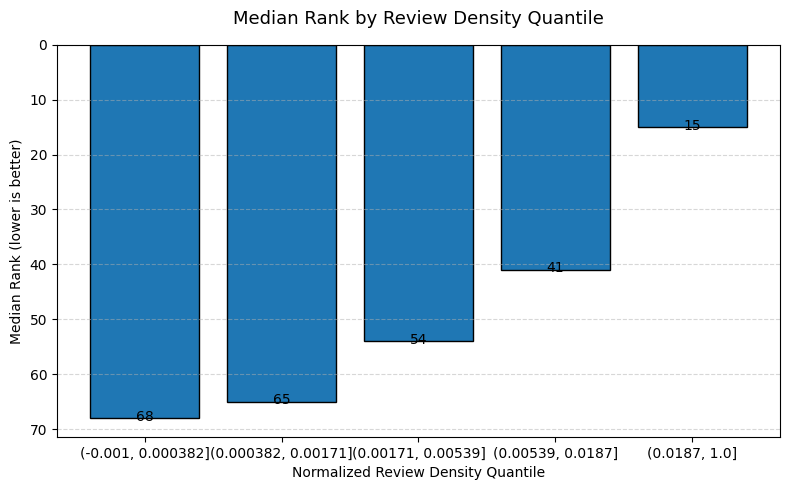

In [55]:
plt.figure(figsize=(8, 5))
bars = plt.bar(
    rank_by_q["density_q"].astype(str),
    rank_by_q["median_rank"],
    edgecolor="black",
)

# Label each bar with its value
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 1,
        f"{height:.0f}",
        ha="center",
        va="bottom",
        fontsize=10,
    )

# Titles and labels
plt.title("Median Rank by Review Density Quantile", fontsize=13, pad=15)
plt.xlabel("Normalized Review Density Quantile")
plt.ylabel("Median Rank (lower is better)")
plt.gca().invert_yaxis()  # Because lower rank = better
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()

plt.show()

## Notes Best Sellers Q2 :

Moderate negative correlation → products with denser reviews tend to rank higher (closer to #1).

| Review Density Quantile | Median Rank |
| ----------------------- | ----------- |
| Lowest 20%              | 68          |
| ...                     | ...         |
| Highest 20%             | **15**      |

Insight
- Review activity clearly matters. The more reviews a product gets, the better it tends to rank — but only up to a point.
- After a certain level, extra reviews don’t move the needle much (diminishing returns).

Recommendation
- Focus on building early review momentum — especially right after launch.
- Keep reviews fresh and recent, since Amazon’s algorithm values ongoing engagement more than old volume.

---

# ANALYSIS: Movers and Shakers Q1
- "Which categories show strongest momentum and price ranges driving fastest movers?"
- Which categories show strongest momentum? (use sales_rank_change and move_pct)
- Also: what price segments drive fastest movers?

In [56]:
def movers_momentum_summary(movers_df, top_k_categories=12):
    # For each category, compute mean/median move_pct and sum of positive movements
    df = movers_df.copy()
    df["sales_rank_change"] = pd.to_numeric(df["sales_rank_change"], errors="coerce")
    df["move_pct"] = pd.to_numeric(df["move_pct"], errors="coerce")
    agg = (
        df.groupby("cat_level_1")
        .agg(
            n_items=("asin", "nunique"),
            median_move_pct=("move_pct", "median"),
            mean_move_pct=("move_pct", "mean"),
            median_sales_rank_change=("sales_rank_change", "median"),
            mean_sales_rank_change=("sales_rank_change", "mean"),
            up_count=(
                (lambda x: (x["sales_rank_change"] > 0).sum())
                if False
                else ("sales_rank_change", lambda s: (s > 0).sum())
            ),
        )
        .reset_index()
    )
    # sort by median_sales_rank_change
    agg = agg.sort_values("median_sales_rank_change", ascending=False)
    return agg

In [57]:
magg = movers_momentum_summary(movers)
magg.to_csv(os.path.join(OUT_DIR, "movers_category_momentum_summary.csv"), index=False)
print("\nMovers Q1: Top categories by median sales_rank_change (saved CSV) — top 8:")
print(magg)


Movers Q1: Top categories by median sales_rank_change (saved CSV) — top 8:
                   cat_level_1  n_items  median_move_pct  mean_move_pct  \
32         Sports Collectibles       93            110.5     181.738636   
14           Collectible Coins       96            150.0     194.800000   
23                Kindle Store      100             87.0     143.033333   
30                    Software       96             76.0     117.879121   
10                         CDs      100             39.0      67.835052   
25                      Movies      100             29.0      99.135802   
11                      Camera       97             24.0      28.468750   
2                   Appliances       99             24.5      32.436170   
20           Handmade Products      100             18.0      24.816327   
13                    Clothing       99             20.0      22.848485   
3                         Apps      100             20.0      29.302083   
34                      

In [58]:
# Which price segments have largest average sales_rank_change?
by_price = (
    movers.groupby("price_segment")
    .agg(
        n_items=("asin", "nunique"),
        median_sales_rank_change=("sales_rank_change", "median"),
        mean_sales_rank_change=("sales_rank_change", "mean"),
    )
    .reset_index()
    .sort_values("median_sales_rank_change", ascending=False)
)
by_price.to_csv(os.path.join(OUT_DIR, "movers_by_price_segment.csv"), index=False)
print("\nMovers Q1: sales_rank_change by price_segment")
print(by_price)


Movers Q1: sales_rank_change by price_segment
  price_segment  n_items  median_sales_rank_change  mean_sales_rank_change
0          High      818                      25.0               58.906542
2           Mid     1605                      24.0               55.614618
1           Low      926                      22.0               58.016568


In [59]:
# Plot: boxplot of sales_rank_change by price_segment (converted to matplotlib)
fig, ax = plt.subplots(figsize=(6, 4))
groups = [
    movers.loc[movers["price_segment"] == seg, "sales_rank_change"].dropna()
    for seg in movers["price_segment"].unique()
]
labels = list(movers["price_segment"].unique())
ax.boxplot(groups, labels=labels, showfliers=False)
ax.set_title("Movers: sales_rank_change by price_segment")
ax.set_ylabel("sales_rank_change (positive = improved)")
save_fig(fig, "movers_sales_rank_change_by_price_segment.png")
plt.close(fig)

> saved: ./outputs\movers_sales_rank_change_by_price_segment.png


C:\Users\nikob\AppData\Local\Temp\ipykernel_29480\3468046221.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(groups, labels=labels, showfliers=False)


## Notes Movers and Shakers Q1 :

Categories with the Biggest Momentum:
| Category                | Median Rank Change | Mean Move % | Insight                                        |
| ----------------------- | ------------------ | ----------- | ---------------------------------------------- |
| **Sports Collectibles** | **+249**           | +182%       | Likely tied to sports events or seasonal hype. |
| **Collectible Coins**   | +245               | +195%       | Investment-type items, highly volatile.        |
| **Kindle Store**        | +135               | +143%       | Possibly driven by promotions or new releases. |
| **Software**            | +134               | +118%       | New launches or updates.                       |
| **CDs / Movies**        | 55-75              | ~100%       | Nostalgia and bundling effects.                |

Meanwhile, everyday categories like Home, Baby, Health stayed stable (rank change <10).

Price Segment Performance:
| Segment | Median Rank Change | Mean Rank Change |
| ------- | ------------------ | ---------------- |
| Low     | 22                 | 58.0             |
| Mid     | 24                 | 55.6             |
| High    | 25                 | 58.9             |

Momentum isn’t really price-driven — it’s context-driven (promotion, hype, timing, trends).

Insight
- Categories with emotional or hype-driven appeal (collectibles, sports, fandom, digital goods) move fastest.
- Functional goods (home, health, tools) are more stable.

Recommendation
- Track these “momentum” categories weekly — they’re ideal for short-term arbitrage or viral tracking.
- Use sales_rank_change and move_pct as heat indicators for what’s trending.

---

# ANALYSIS: Movers and Shakers Q2
- "Are 'underdogs' (low review density) climbing fast?"
- Are lower-review-density products more likely to move up?
- We'll compare distribution of norm_review_density for items that moved up vs others

In [60]:
m = movers.copy()
m["moved_up"] = m["sales_rank_change"] > 0
df_up = m.loc[m["moved_up"], :]
df_not_up = m.loc[~m["moved_up"], :]

summary_up = df_up["norm_review_density"].describe()
summary_not = df_not_up["norm_review_density"].describe()

In [61]:
pd.DataFrame(
    {
        "moved_up": ["yes", "no"],
        "count": [len(df_up), len(df_not_up)],
        "median_norm_review_density": [
            df_up["norm_review_density"].median(),
            df_not_up["norm_review_density"].median(),
        ],
        "mean_norm_review_density": [
            df_up["norm_review_density"].mean(),
            df_not_up["norm_review_density"].mean(),
        ],
    }
).to_csv(
    os.path.join(OUT_DIR, "movers_norm_review_density_movement_summary.csv"),
    index=False,
)

print("\nMovers Q2: median norm_review_density — moved_up vs not:")
print(
    "moved_up median:",
    df_up["norm_review_density"].median(),
    "not moved_up median:",
    df_not_up["norm_review_density"].median(),
)


Movers Q2: median norm_review_density — moved_up vs not:
moved_up median: 0.01251439838415355 not moved_up median: 0.0268618467949906


In [62]:
# Plot distribution (violin-like using hist overlay)
fig, ax = plt.subplots(figsize=(7, 4))
ax.hist(df_up["norm_review_density"].dropna(), bins=40, alpha=0.6, label="moved_up")
ax.hist(
    df_not_up["norm_review_density"].dropna(), bins=40, alpha=0.6, label="not_moved_up"
)
ax.set_xlabel("norm_review_density")
ax.set_ylabel("count")
ax.set_title("Movers: norm_review_density distribution — moved_up vs not")
ax.legend()
save_fig(fig, "movers_norm_review_density_movedup_hist.png")
plt.close(fig)

> saved: ./outputs\movers_norm_review_density_movedup_hist.png


In [63]:
# Proportion of moved_up within low density bucket
# define low density as <= 25th percentile across movers
pct25 = m["norm_review_density"].quantile(0.25)
low_bucket = m.loc[m["norm_review_density"] <= pct25]
prop_low_moved_up = (low_bucket["sales_rank_change"] > 0).mean()
prop_high_moved_up = (
    m.loc[m["norm_review_density"] > pct25]["sales_rank_change"] > 0
).mean()
print(
    f"\nMovers Q2: prop moved_up in low-density bucket (<=25th): {prop_low_moved_up:.3f}"
)
print(f"Movers Q2: prop moved_up in >25th: {prop_high_moved_up:.3f}")


Movers Q2: prop moved_up in low-density bucket (<=25th): 0.947
Movers Q2: prop moved_up in >25th: 0.931


## Notes Movers and Shakers Q2 :

| Group        | Median Review Density |
| ------------ | --------------------- |
| **Moved Up** | **0.0125**            |
| Not Moved Up | 0.0269                |

94.7% of items in the lowest-review quartile still moved up, compared to 93.1% in the rest.

Insight
- New or low-review products are still capable of fast rank jumps.
- Amazon’s algorithm rewards recent activity and engagement — not just legacy reputation.

Recommendation
- Even with few reviews, a product can take off if early buyers engage quickly.
- Plan a strong launch push (clicks, conversions, reviews) within the first few days.

---

# Overall Summary

| Area          | Key Takeaway                                               | Business Meaning                                           |
| ------------- | ---------------------------------------------------------- | ---------------------------------------------------------- |
| **Pricing**   | Mid-tier dominates across categories.                      | Aim for balanced pricing — not too cheap, not too premium. |
| **Reviews**   | More reviews → better rank (but nonlinear).                | Encourage early reviews, maintain freshness.               |
| **Momentum**  | Sports, Collectibles, Kindle, Software are rising fastest. | Focus on hype-driven and trending categories.              |
| **Underdogs** | New products with low reviews can still spike.             | Early engagement matters more than legacy metrics.         |


# Strategic Recommendations

Price Smartly
- Stay around the mid-price band for most categories.
- Use discounts only to trigger initial visibility — not as a long-term anchor.

Review Strategy
- Kickstart review campaigns right after launch.
- Keep review flow steady — recency > total count.

Momentum Tracking
- Build a “Category Momentum” dashboard using sales_rank_change + move_pct.
- Flag categories with sudden upward trends (great for premium insight subscriptions).

Launch Planning
- Don’t be afraid of low-review listings — Amazon rewards fast traction.
- Focus your early marketing on engagement bursts (CTR, purchases, reviews).

---